In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
import numpy as np

In [2]:
from ML.lr import linear_regression 

In [3]:
# Load the dataset
train_file_path = "./datasets/Train_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
train_data = pd.read_csv(train_file_path)

eval_file_path = "./datasets/Eval_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
eval_data = pd.read_csv(eval_file_path)

In [4]:
#Define levels
levels=5

# Parse relevant columns for all bid and ask levels
bid_columns = [f"bids[{i}].price" for i in range(levels)] + [f"bids[{i}].amount" for i in range(levels)]
ask_columns = [f"asks[{i}].price" for i in range(levels)] + [f"asks[{i}].amount" for i in range(levels)]
feature_columns = bid_columns  + ask_columns
eval_columns=['mark_price','next_mark_price','Price Movement',"actual_direction"]

# Features and target
X_train = train_data[feature_columns]
y_train = train_data['next_mark_price']
# X_test = test_data[feature_columns]
# y_test = test_data["target"]
X_eval = eval_data[feature_columns]

y_eval = eval_data[eval_columns]

In [5]:
linear_regression=linear_regression(X_train,y_train,X_eval)

In [6]:
# if not yet trained
# linear_regression.train()

In [7]:
# Predict 
# Measure the execution time of the function
start_time = time.time()
linear_regression_Predict_data=pd.DataFrame({"predicted_lr":linear_regression.predict()})
end_time = time.time()
execution_time = (end_time - start_time)* 1000 
print(f"Execution_time(Linear Regression): {execution_time:.2f} milliseconds")

Execution_time(Linear Regression): 5.59 milliseconds


In [8]:
# combine data tgt
Evaluate_result=pd.concat([y_eval, linear_regression_Predict_data], axis=1)

In [9]:
# Evaluate performance using MSE on evaluation set
mse_lr = mean_squared_error(Evaluate_result['next_mark_price'], Evaluate_result['predicted_lr'])
print(f"Linear Regression MSE (Eval Set): {mse_lr:.2f}")

Linear Regression MSE (Eval Set): 25.41


In [10]:
# Calculate directional accuracy
Evaluate_result.loc[:, "predicted_direction_lr"] = np.sign(Evaluate_result["predicted_lr"] - Evaluate_result["next_mark_price"])
directional_accuracy_lr = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_lr"]).mean()
print(f"Directional Accuracy (Linear Regression): {directional_accuracy_lr:.2%}")

Directional Accuracy (Linear Regression): 29.83%


In [11]:
# Tolerance-Based Accuracy
tolerance = 0.0001 * Evaluate_result["next_mark_price"].mean()  # Set tolerance to 0.01% of average price
Evaluate_result.loc[:, "tolerance_lr"] = abs(Evaluate_result["predicted_lr"] - Evaluate_result["next_mark_price"]) <= tolerance

# Calculate tolerance-based accuracy
tolerance_accuracy_lr = Evaluate_result["tolerance_lr"].mean()

print(f"Tolerance-Based Accuracy (Linear Regression): {tolerance_accuracy_lr:.2%}")

Tolerance-Based Accuracy (Linear Regression): 80.95%


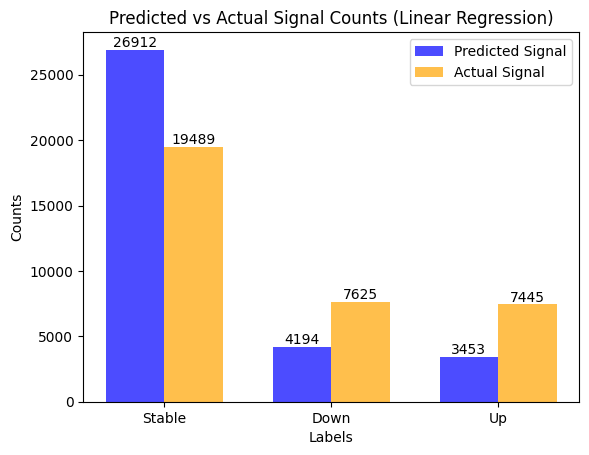

In [12]:
# Add symbol columns based on comparison with the last mark price
symbol_tolerance = 0.0001 * eval_data["next_mark_price"].mean()  # Adjust as needed
Evaluate_result.loc[:, "symbol_lr"] = None

for i in range(len(Evaluate_result)):

    # Linear Regression symbol logic
    if Evaluate_result["predicted_lr"].iloc[i] > Evaluate_result["mark_price"].iloc[i] + symbol_tolerance:
        Evaluate_result.loc[Evaluate_result.index[i], "symbol_lr"] = "up"
    elif Evaluate_result["predicted_lr"].iloc[i] < Evaluate_result["mark_price"].iloc[i] - symbol_tolerance:
        Evaluate_result.loc[Evaluate_result.index[i], "symbol_lr"] = "down"
    else:
        Evaluate_result.loc[Evaluate_result.index[i], "symbol_lr"] = "stable"

# Visualize symbol distributions
symbol_counts_lr = Evaluate_result["symbol_lr"].value_counts()
Actual_signal_counts = Evaluate_result["Price Movement"].value_counts()

lr_predict_values = symbol_counts_lr.values.tolist()
actual_values = Actual_signal_counts.values.tolist()

labels = Actual_signal_counts.index.tolist()

# Setting the positions and width for the bars
positions = np.arange(len(labels))
bar_width = 0.35


# Create the bar plot
bar1=plt.bar(positions, lr_predict_values, bar_width, label='Predicted Signal', color='b', alpha=0.7)
bar2=plt.bar(positions + bar_width, actual_values, bar_width, label='Actual Signal', color='orange', alpha=0.7)

# Adding labels, title, and legend
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Predicted vs Actual Signal Counts (Linear Regression)')
plt.xticks(positions + bar_width / 2, labels)
plt.legend()

# Displaying the values on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')


plt.show()

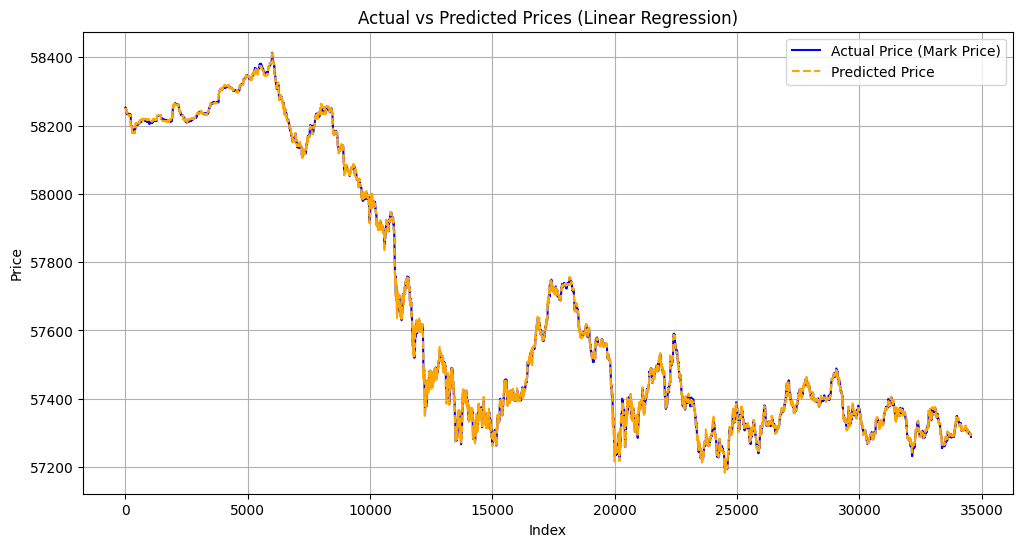

In [13]:
# Visualize the actual vs. predicted price along with signals
plt.figure(figsize=(12, 6))
plt.plot(Evaluate_result["mark_price"], label="Actual Price (Mark Price)", color="blue")
plt.plot(Evaluate_result["predicted_lr"], label="Predicted Price", color="orange", linestyle="--")
plt.title("Actual vs Predicted Prices (Linear Regression)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()
